In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import os
from sklearn.metrics import r2_score
from scipy import stats
%matplotlib inline

In [ ]:

# Loading data
df = pd.read_excel("data/Absenteeism_at_work_Project.xlsx")

# Project 1 — Data Processing

The modeling section depends on preprocessing. In this stage we handle outliers, impute missing values, remove unnecessary columns, construct the target column, and apply additional preprocessing steps to improve classification performance.

In [ ]:
# First 5 rows of data
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0
2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0
3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,...,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0


In [ ]:
# The ID column is not informative for modeling and will be removed
df = df.drop(['ID'], axis=1)

In [ ]:
# To obtain basic statistics for the target variable, we examine its mean and variance
print(df.loc[:, 'Absenteeism time in hours'].mean())
print(df.loc[:, 'Absenteeism time in hours'].min())
print(df.loc[:, 'Absenteeism time in hours'].max())

6.977715877437326
0.0
120.0


In [ ]:
df['Absenteeism time in hours'].value_counts()

8.0      199
2.0      155
3.0      110
1.0       88
4.0       60
0.0       36
16.0      19
24.0      16
40.0       7
5.0        7
32.0       5
64.0       3
80.0       3
120.0      3
56.0       2
112.0      2
104.0      1
7.0        1
48.0       1
Name: Absenteeism time in hours, dtype: int64

In [ ]:
# For easier classification we discretize the target into three categories: less than 6 hours, between 6 and 30 hours, and greater than 30 hours
df['Absenteeism time in hours'] = np.where(df['Absenteeism time in hours'] < 6, 1, df['Absenteeism time in hours'])
df['Absenteeism time in hours'] = np.where(df['Absenteeism time in hours'].between(6, 30), 2, df['Absenteeism time in hours'])
df['Absenteeism time in hours'] = np.where(df['Absenteeism time in hours'] > 30, 3, df['Absenteeism time in hours'])

In [ ]:
df['Absenteeism time in hours'].value_counts()

1.0    456
2.0    235
3.0     27
Name: Absenteeism time in hours, dtype: int64

The feature 'Reason for absence' must be removed because it has strong leakage with the target.


In [ ]:
df = df.drop(['Reason for absence'], axis=1)
df

,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,97.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,1.0
1,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,1.0
2,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,97.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,1.0
3,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,97.0,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,1.0
4,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,97.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,7.0,3,1,289.0,36.0,13.0,33.0,264604.0,93.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0
736,7.0,3,1,235.0,11.0,14.0,37.0,264604.0,93.0,0.0,3.0,1.0,0.0,0.0,1.0,88.0,172.0,29.0,1.0
737,0.0,3,1,118.0,14.0,13.0,40.0,271219.0,95.0,0.0,1.0,1.0,1.0,0.0,8.0,98.0,170.0,34.0,1.0
738,0.0,4,2,231.0,35.0,14.0,39.0,271219.0,95.0,0.0,1.0,2.0,1.0,0.0,2.0,100.0,170.0,35.0,1.0


Using the following function, we determine the data type of each feature in the dataset.

In [ ]:
# Data Types of all the variables
df.dtypes

Month of absence                   float64
Day of the week                      int64
Seasons                              int64
Transportation expense             float64
Distance from Residence to Work    float64
Service time                       float64
Age                                float64
Work load Average/day              float64
Hit target                         float64
Disciplinary failure               float64
Education                          float64
Son                                float64
Social drinker                     float64
Social smoker                      float64
Pet                                float64
Weight                             float64
Height                             float64
Body mass index                    float64
Absenteeism time in hours          float64
dtype: object

The following function computes the number of unique elements for each feature column.

In [ ]:
# Number of Unique values present in each variable
df.nunique()

Month of absence                   13
Day of the week                     5
Seasons                             4
Transportation expense             24
Distance from Residence to Work    25
Service time                       18
Age                                22
Work load Average/day              38
Hit target                         13
Disciplinary failure                2
Education                           4
Son                                 5
Social drinker                      2
Social smoker                       2
Pet                                 6
Weight                             26
Height                             14
Body mass index                    17
Absenteeism time in hours           3
dtype: int64

In [ ]:
# Our dataset contains 742 samples in total; each sample has 21 features
df.shape

(740, 19)

In [ ]:
# After inspection we identify two feature types in the dataset: categorical and continuous (numerical)
continuous_vars = ['Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Transportation expense',
       'Hit target', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']

categorical_vars = ['ID','Reason for absence','Month of absence','Day of the week',
                     'Seasons','Disciplinary failure', 'Education', 'Social drinker',
                     'Social smoker', 'Pet', 'Son']

# Missing Value Analysis
The following cell computes the number of missing values per feature. For convenience we create a pandas DataFrame and calculate the percentage of missing values for each column.

In [ ]:
missing_val = pd.DataFrame(df.isnull().sum()).reset_index()


missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df))*100

missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

missing_val.to_csv("Missing_perc.csv", index = False)

In [ ]:
# Approximately 4% of the data is missing. The printout indicates that the missing values are primarily in the 'Body mass index' feature.

missing_val

,Variables,Missing_percentage
0,Body mass index,4.189189
1,Absenteeism time in hours,2.972973
2,Height,1.891892
3,Education,1.351351
4,Work load Average/day,1.351351
5,Transportation expense,0.945946
6,Hit target,0.810811
7,Son,0.810811
8,Disciplinary failure,0.810811
9,Social smoker,0.540541


## Imputation methods
Since the target is the feature at index 20, missing values in this column would introduce fitting errors. Therefore we remove rows with missing values in column 20. This operation removes 32 records from the dataset.

In [ ]:

df = df.drop(df[df['Absenteeism time in hours'].isnull()].index, axis=0)
print(df.shape)
print(df['Absenteeism time in hours'].isnull().sum())

(718, 19)
0


Because only a small percentage of values are missing in other features, we impute missing values using the feature mean. After imputation no missing values remain.

In [ ]:

df.fillna(df.median(),inplace=True)
df.isnull().sum()

Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

In [ ]:
df.describe()

,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,6.264624,3.899721,2.532033,220.441504,29.571031,12.598886,36.476323,271241.743733,94.614206,0.045961,1.296657,1.009749,0.565460,0.071031,0.740947,79.094708,172.077994,26.637883,1.402507
std,3.437370,1.419519,1.105813,65.851033,14.757069,4.367127,6.468796,38703.882235,3.797550,0.209547,0.678225,1.080402,0.496042,0.257055,1.310730,12.844394,6.001119,4.216566,0.562267
min,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205917.000000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000
25%,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244387.000000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,1.000000
50%,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264249.000000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,1.000000
75%,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,284853.000000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,2.000000
max,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378884.000000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,3.000000


In [ ]:
df.loc[0]

Month of absence                        7.0
Day of the week                         3.0
Seasons                                 1.0
Transportation expense                289.0
Distance from Residence to Work        36.0
Service time                           13.0
Age                                    33.0
Work load Average/day              239554.0
Hit target                             97.0
Disciplinary failure                    0.0
Education                               1.0
Son                                     2.0
Social drinker                          1.0
Social smoker                           0.0
Pet                                     1.0
Height                                172.0
Body mass index                        30.0
Absenteeism time in hours               1.0
Name: 0, dtype: float64

# OutLier Analysis

Text(0, 0.5, 'Values')

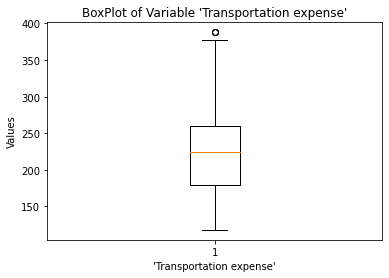

In [ ]:
# Ploting BoxPlot of continuous variables
plt.boxplot(df['Transportation expense'])
plt.xlabel("'Transportation expense'")
plt.title("BoxPlot of Variable 'Transportation expense'")
plt.ylabel('Values')

Text(0, 0.5, 'Values')

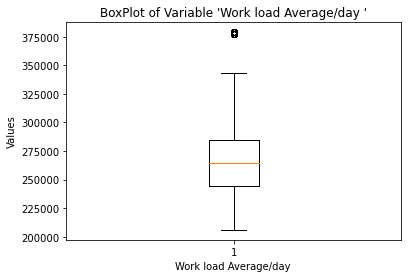

In [ ]:
plt.boxplot(df['Work load Average/day '])
plt.xlabel("Work load Average/day ")
plt.title("BoxPlot of Variable 'Work load Average/day '")
plt.ylabel('Values')

Text(0, 0.5, 'Values')

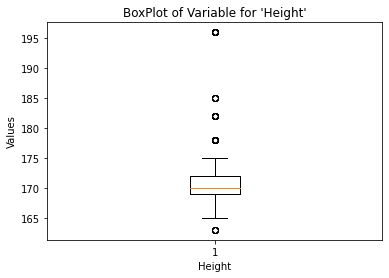

In [ ]:
plt.boxplot(df['Height'])
plt.xlabel("Height")
plt.title("BoxPlot of Variable for 'Height'")
plt.ylabel('Values')

Text(0, 0.5, 'Values')

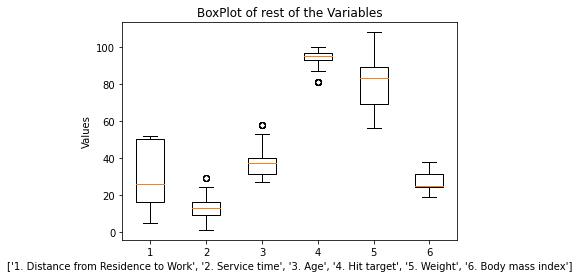

In [ ]:
plt.boxplot([ df['Distance from Residence to Work'], df['Service time'], df['Age'], df['Hit target'], df['Weight'], df['Body mass index']])
plt.xlabel(['1. Distance from Residence to Work', '2. Service time', '3. Age', '4. Hit target', '5. Weight', '6. Body mass index'])
plt.title("BoxPlot of rest of the Variables")
plt.ylabel('Values')

From comparison of the above plots we conclude that the dataset does not contain significant outliers in the following numeric features: 'Distance from Residence to Work', 'Weight', 'Body mass index'.

In [ ]:

# In this section outliers are replaced with the feature mean
for i in continuous_vars:
    print(i)
    q75, q25=np.percentile(df.loc[:,i],[75,25])
    iqr=q75-q25

    min=q25-(iqr*1.5)
    max=q75+(iqr*1.5)

    print(min)
    print(max)

    # Replace all the outliers value to NA
    df.loc[df[i]< min,i] = np.nan
    df.loc[df[i]> max,i] = np.nan
    df.fillna(df.median(),inplace=True)


Distance from Residence to Work
-35.0
101.0
Service time
-1.5
26.5
Age
17.5
53.5
Work load Average/day 
183688.0
345552.0
Transportation expense
57.5
381.5
Hit target
87.0
103.0
Weight
39.0
119.0
Height
164.5
176.5
Body mass index
13.5
41.5
Absenteeism time in hours
-0.5
3.5


# Feature Selection

In [ ]:
##Correlation analysis for continuous variables
#Correlation plot
df_corr = df.loc[:,continuous_vars]

<ipython-input-29-5b8c1c8a529f>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


[]

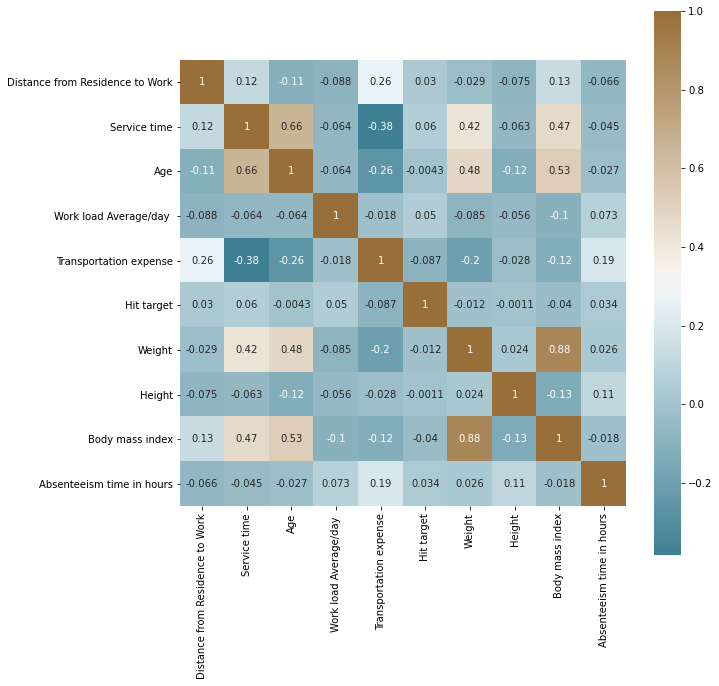

In [ ]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(10, 10))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 50, as_cmap=True),
            square=True, ax=ax, annot = True)
plt.plot()

In [ ]:
corr

,Distance from Residence to Work,Service time,Age,Work load Average/day,Transportation expense,Hit target,Weight,Height,Body mass index,Absenteeism time in hours
Distance from Residence to Work,1.000000,0.117918,-0.108980,-0.088384,0.261657,0.030380,-0.029291,-0.074740,0.130864,-0.065727
Service time,0.117918,1.000000,0.658849,-0.064005,-0.382535,0.060251,0.420772,-0.063323,0.466036,-0.044804
Age,-0.108980,0.658849,1.000000,-0.063793,-0.263658,-0.004315,0.484454,-0.122222,0.533495,-0.026657
Work load Average/day,-0.088384,-0.064005,-0.063793,1.000000,-0.018045,0.049781,-0.085050,-0.056125,-0.103561,0.072782
Transportation expense,0.261657,-0.382535,-0.263658,-0.018045,1.000000,-0.086927,-0.200054,-0.028124,-0.119882,0.191688
Hit target,0.030380,0.060251,-0.004315,0.049781,-0.086927,1.000000,-0.011665,-0.001137,-0.039642,0.033559
Weight,-0.029291,0.420772,0.484454,-0.085050,-0.200054,-0.011665,1.000000,0.024065,0.884206,0.025613
Height,-0.074740,-0.063323,-0.122222,-0.056125,-0.028124,-0.001137,0.024065,1.000000,-0.134353,0.107026
Body mass index,0.130864,0.466036,0.533495,-0.103561,-0.119882,-0.039642,0.884206,-0.134353,1.000000,-0.017853
Absenteeism time in hours,-0.065727,-0.044804,-0.026657,0.072782,0.191688,0.033559,0.025613,0.107026,-0.017853,1.000000


In [ ]:
# The correlation matrix shows that 'Weight' is the most inconsistent feature relative to others; therefore it will be removed.
to_drop = ['Weight']
df = df.drop(to_drop, axis = 1)

In [ ]:
# Updating the Continuous Variables and Categorical Variables after droping some variables
continuous_vars = [i for i in continuous_vars if i not in to_drop]
categorical_vars = [i for i in categorical_vars if i not in to_drop]

In [ ]:
clean_data = df.copy()

# Feature Scaling

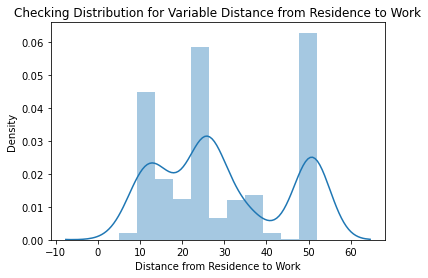

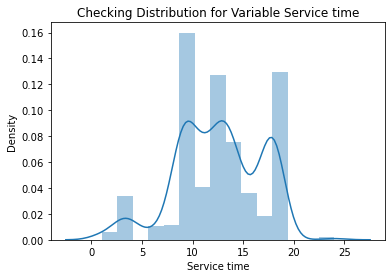

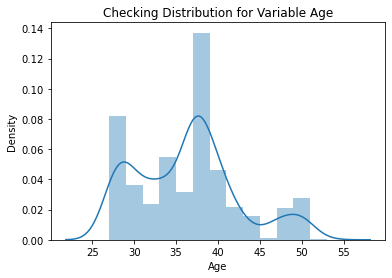

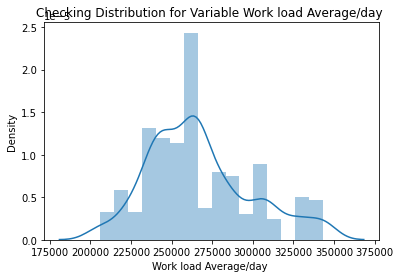

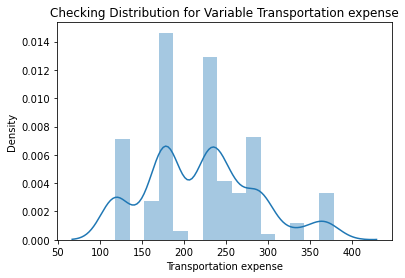

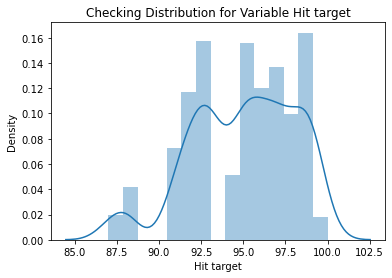

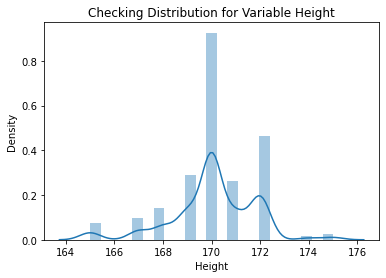

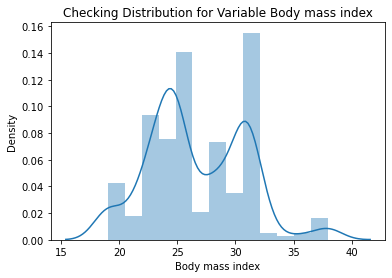

In [ ]:
# To normalize the dataset, we first check the distribution of each continuous variable
for i in continuous_vars:
    if i == 'Absenteeism time in hours':
        continue
    sns.distplot(df[i],bins = 'auto')
    plt.title("Checking Distribution for Variable "+str(i))
    plt.ylabel("Density")
    plt.show()

None of the features follow a uniform distribution. We therefore normalize each feature by subtracting the minimum and dividing by the variance (note: scaling method is min-relative and variance normalization).


In [ ]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()

y = df['Absenteeism time in hours'].to_numpy()
X_conti = scal.fit_transform(df[continuous_vars].drop('Absenteeism time in hours',axis = 1).to_numpy())
X_all = scal.fit_transform(df.drop('Absenteeism time in hours',axis = 1).to_numpy())

In [ ]:
X_conti[0]

array([ 0.43595723,  0.12372452, -0.53613576, -0.85030536,  1.0667863 ,
        0.65861285,  1.13284874,  0.79791491])

# Machine Learning Models

In [ ]:
#df = pd.get_dummies(data = df, columns = categorical_vars)

In [ ]:
df['Absenteeism time in hours']

In [ ]:
set(y)

In [ ]:
X_conti[0]

In [ ]:
X_all[0]

We split the dataset into training and test sets using a 80/20 ratio. We perform two experiments: one using only continuous features and another using all features. The model that uses all features performs better.

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_conti, y, test_size = 0.20, random_state=42)
Xall_train, Xall_test, yall_train, yall_test = train_test_split( X_all, y, test_size = 0.20, random_state=42)

In [ ]:
X_train.shape


(574, 8)

# K-Nearest Neighbors implementation

Euclidean distance between two points

In [ ]:
import math
def euclideanDistance(p1, p2):

    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist

Finding the nearest neighbors

In [ ]:
import operator
def getKNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for index, x in enumerate(trainingSet):

        dist = euclideanDistance(testInstance, x)
        distances.append((index, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [ ]:
def get_vote(neighbors, y_train):
    classVotes = {}
    for x in neighbors :
        label = y_train[x]
        if label in classVotes:
            classVotes[label] += 1
        else:
            classVotes[label] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [ ]:
def knn(x_train, y_train, x_test, k):
    y_pred = []
    for index, sample in enumerate(x_test):
        neighbors = getKNeighbors(x_train, sample, k)
        label = get_vote(neighbors, y_train)
        y_pred.append([index, label])

    return np.array(y_pred)

In [ ]:
# Implementation using numerical (continuous) features
y_pred = knn(X_train, y_train, X_test,5)

In [ ]:
y_pred[:, 1]

In [ ]:
# importing accuracy_score
from sklearn.metrics import accuracy_score

# printing accuracy
print(accuracy_score(y_test,y_pred[:,1]))

In [ ]:
# Implementation using all features
y_pred = knn(Xall_train, yall_train, Xall_test,5)

In [ ]:
print(accuracy_score(yall_test,y_pred[:,1]))

## sklearn  KNeighborsClassifier

In [ ]:
#
from sklearn.neighbors import KNeighborsClassifier


classifer = KNeighborsClassifier(n_neighbors=5 )

# Implementation using numerical features
classifer.fit(X_train,y_train)

# testing the model
y_pred= classifer.predict(X_test)

In [ ]:
# printing accuracy
print(accuracy_score(y_test,y_pred))

In [ ]:
classifer = KNeighborsClassifier(n_neighbors=5)

# پیاده سازی با تمام داده ها
classifer.fit(Xall_train,yall_train)

# testing the model
y_pred= classifer.predict(Xall_test)

In [ ]:
print(accuracy_score(yall_test,y_pred))

Earlier we implemented the algorithm manually and obtained 64% accuracy using numerical features. The scikit-learn KNeighborsClassifier produces similar accuracy.


To evaluate the effect of the number of neighbors, we test the model with various k values. As k increases the model accuracy increases, reaching 68% for k=15 on the linear dataset.

In [ ]:
k = [1, 3, 5, 10, 15]
for i in k:
    classifer = KNeighborsClassifier(n_neighbors=i)
    classifer.fit(X_train,y_train)

    # testing the model
    y_pred= classifer.predict(X_test)
    print('accuracy_score wen k is%d='%i,accuracy_score(y_test,y_pred))

# Dimensionality Reduction using PCA

In this section we train the model after applying Principal Component Analysis (PCA). Applying PCA components improves model performance.

In [ ]:
target = df['Absenteeism time in hours']


In [ ]:
target

In [ ]:
df.drop(['Absenteeism time in hours'], inplace = True, axis=1)
df.shape

In [ ]:
from sklearn.decomposition import PCA

# Data has 129 variables so no of components of PCA = 129
pca = PCA(n_components=8)
pca.fit(X_all)

# The amount of variance that each PC explains
var= pca.explained_variance_ratio_

# Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)
plt.show()

In [ ]:
# From the above plot selecting 45 components since it explains almost 95+ % data variance
pca = PCA()

# Fitting the selected components to the data
Xconti_transform = pca.fit_transform(X_conti)
Xall_transform = pca.fit_transform(X_all)
# Using train_test_split sampling function for test and train data split
X_train, X_test, y_train, y_test = train_test_split( Xconti_transform, y, test_size = 0.20, random_state=42)
Xall_train, Xall_test, yall_train, yall_test = train_test_split( Xall_transform, y, test_size = 0.20, random_state=42)

In [ ]:
Xconti_transform[0]

In [ ]:
Xall_transform.shape

KNeighborsClassifier with pca

In [ ]:
# importing KNN algorithm
from sklearn.neighbors import KNeighborsClassifier


classifer = KNeighborsClassifier(n_neighbors=5 )

# model training
classifer.fit(X_train,y_train)

# testing the model
y_pred= classifer.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_pred))

In [ ]:
classifer = KNeighborsClassifier(n_neighbors= 5 )

# model training
classifer.fit(Xall_train,yall_train)

# testing the model
y_pred= classifer.predict(Xall_test)

In [ ]:
print(accuracy_score(yall_test,y_pred))

# Relationship of "Absenteeism time in hours" with others